In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
#function to calculate the projective homography between two images
def proj_homography(dcord,rcord):
    A = np.zeros((8,8))
    B = np.zeros((8,1))
    H = np.ones((3,3))
 
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(4):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
 
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
 
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
 
 
    C = np.dot(np.linalg.pinv(A),B);
 
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
 
    return H


In [3]:
#function to calculate the homography between two images using inhomogeneous linear least square
def LLS_homography(dcord,rcord):
    n = dcord.shape[0]
    A = np.zeros((2*n,8))
    B = np.zeros((2*n,1))
    H = np.ones((3,3))
 
    #Generating the matrix equation AB = C using the coordinates of the ROIs 
    for i in range(n):
        A[2*i,0] = dcord[i,0]
        A[2*i,1] = dcord[i,1]
        A[2*i,2] = 1
        A[2*i,6] = -1*dcord[i,0]*rcord[i,0]
        A[2*i,7] = -1*dcord[i,1]*rcord[i,0]
 
        A[2*i+1,3] = dcord[i,0]
        A[2*i+1,4] = dcord[i,1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1*dcord[i,0]*rcord[i,1]
        A[2*i+1,7] = -1*dcord[i,1]*rcord[i,1]
 
        B[2*i,0] = rcord[i,0]
        B[2*i+1,0] = rcord[i,1]
 
 
    C = np.dot(np.linalg.pinv(A),B);
 
    #Obtaining the Homography H
    for i in range(3):
        for j in range(3):
            if i==2 & j ==2:
                break
            H[i,j]=C[3*i +j,0]
 
    return H


In [4]:
#obtaining the (x,y) coordinates from a keypoint
def coords(good,kp1,kp2):
    coord1=[]
    coord2=[]
    
    for i in good:
        idx1 = i[0].queryIdx
        idx2 = i[0].trainIdx
        
        t1 = kp1[idx1].pt
        t2 = kp2[idx2].pt
        
        coord1.append([t1[0],t1[1]])
        coord2.append([t2[0],t2[1]])
        
    return coord1,coord2
        
    
    

In [5]:
#Returns the inliers for a given homography H
def theinliers(H,im1,im2,delta):
    him1 = np.insert(im1,2,1,axis=1)
    him2 = np.insert(im2,2,1,axis=1)
    
    him2_calc = np.matmul(H,him1.T)
    im2_calc = him2_calc/him2_calc[2,:]
    im2_calc = im2_calc[0:2,:].T
    error  = np.abs(im2-im2_calc)
    t_error = np.sum(error**2,axis=1)
    
    idx = np.where(t_error<delta)[0]
    
    return idx
    

In [6]:
#Funtion to return the Jacobian and the error
def jacobian(h,dcoord,rcoord):
    X = []
    F = []
    J = []
    
    for i in range(len(dcoord)):
        X.append(rcoord[i,0])
        X.append(rcoord[i,1])
        
        deno = h[6]*dcoord[i,0]+h[7]*dcoord[i,1]+h[8]
        f1 = (h[0]*dcoord[i,0]+h[1]*dcoord[i,1]+h[2])/deno
        f2 = (h[3]*dcoord[i,0]+h[4]*dcoord[i,1]+h[5])/deno
        F.append(f1)
        F.append(f2)

        J.append(rcoord[i,0]/deno)
        J.append(rcoord[i,1]/deno)
        J.append(1)
        
        J.append(0)
        J.append(0)
        J.append(0)
        
        J.append(-(f1*rcoord[i,0])/deno)
        J.append(-(f1*rcoord[i,1])/deno)
        J.append(-f1/deno)
        
        J.append(0)
        J.append(0)
        J.append(0)
        
        J.append(rcoord[i,0]/deno)
        J.append(rcoord[i,1]/deno)
        J.append(1)
                
        J.append(-(f2*rcoord[i,0])/deno)
        J.append(-(f2*rcoord[i,1])/deno)
        J.append(-f2/deno)
        
    X = np.array(X)
    F = np.array(F)
    J = np.array(J)
    J = J.reshape(-1,9)
    
    error = X-F
    return error, -J
        
        

In [14]:
#My implementation of Levenberg-Marquardt algorithm
def LM(h,dcoord,rcoord):
    t = 0.5
    pk = h
    error,J = jacobian(h,dcoord,rcoord)
    JTJ = np.matmul(J.T,J)
    I = np.eye(JTJ.shape[0])
    muk = t*np.diag(JTJ).max()
    
    
    while (True):
        
        error,J = jacobian(pk,dcoord,rcoord)
        JTJ = np.matmul(J.T,J)
        JTE = -J.T@error
        delp = np.linalg.pinv(JTJ + muk*I)@JTE
        pk1 = pk + delp
        cost = error.T@error
        
        error1,J1 = jacobian(pk1,dcoord,rcoord)
        cost1 = error1.T@error1
        rho = (cost-cost1)/(delp.T@JTE + delp.T@(muk*delp))
        muk1 = muk*max(1/3,1-(2*rho - 1)**3)
        muk = muk1
        
        if cost-cost1>=0:
            pk = pk1
            
            if np.linalg.norm(delp)<0.00000000000001:
                
                break
                
    return pk
        

In [8]:
#Own LM function wrapper
def LM_own(dcoord,rcoord,H):
    h  = H.flatten()
    h_LM = LM(h,dcoord,rcoord)
    H_LM = h_LM.reshape((3,3))
    return H_LM

In [9]:
#Implementation of RANSAC and resultant homography is refined using my LM method
def RANSAC_own(good,kp1,kp2):
    delta = 3.0
    p = 0.99
    epsilon = 0.5
    n = 4
    ntotal = len(good)
    N = np.log(1-p)/np.log(1-(1-epsilon)**n)
    N = int(N)
    M = (1-epsilon)*ntotal
    
    Im1,Im2 = coords(good,kp1,kp2)
    im1 = np.asarray(Im1)
    im2 = np.asarray(Im2)
    
    most_inliers = []
    max_inliers=0
    
    for i in range(N):
        idx = np.random.choice(list(range(ntotal)),n)
        
        Dcord=[]
        Rcord=[]
        for j in idx:
            Dcord.append(im1[j])
            Rcord.append(im2[j])
        dcord = np.asarray(Dcord)
        rcord = np.asarray(Rcord)
        H = proj_homography(dcord,rcord)
        inliers = theinliers(H,im1,im2,delta**2)
        if len(inliers)>M and len(inliers)>max_inliers:
            max_inliers = len(inliers)
            most_inliers = inliers
            
    H_final = LLS_homography(im1[most_inliers],im2[most_inliers])
    H_finals = LM_own(im1[most_inliers],im2[most_inliers],H_final)
        
    return H_final,H_finals,most_inliers

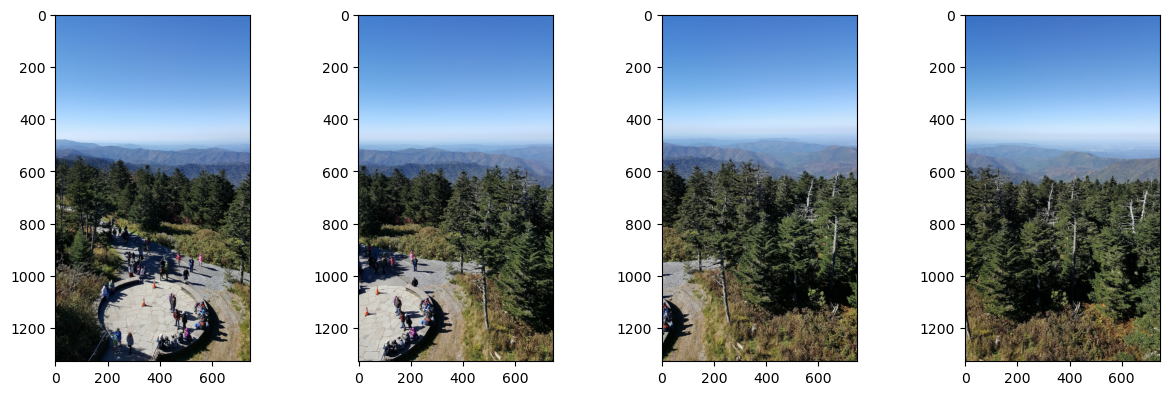

In [10]:
#displaying the 4 images of the scene for Task1
oimga1 = cv2.imread ("1.jpg")
oimgb1 = cv2.imread ("2.jpg")
oimgc1 = cv2.imread ("3.jpg")
oimgd1 = cv2.imread ("4.jpg")

cimga1 = cv2.cvtColor(oimga1, cv2.COLOR_BGR2RGB)
cimgb1 = cv2.cvtColor(oimgb1, cv2.COLOR_BGR2RGB)
cimgc1 = cv2.cvtColor(oimgc1, cv2.COLOR_BGR2RGB)
cimgd1 = cv2.cvtColor(oimgd1, cv2.COLOR_BGR2RGB)

f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

ax1.imshow(cimga1)
ax2.imshow(cimgb1)
ax3.imshow(cimgc1)
ax4.imshow(cimgd1)

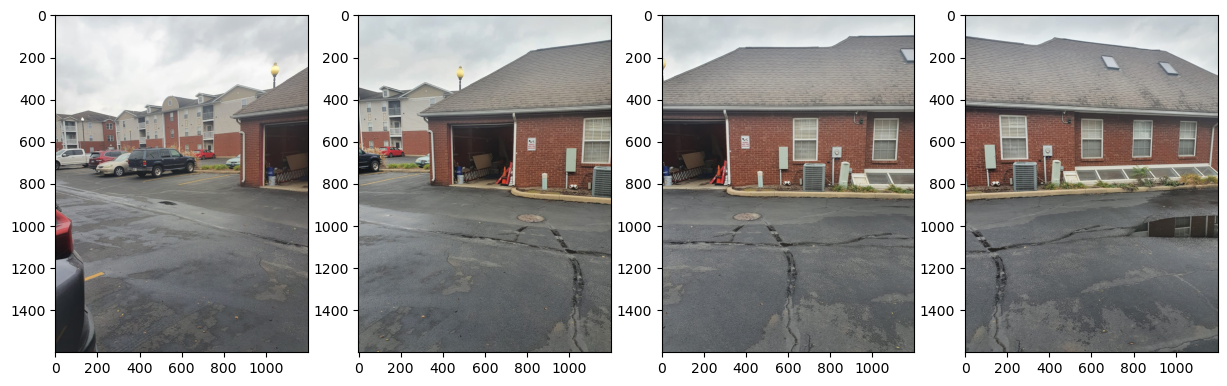

In [11]:
#displaying the 4 images of the scene for Task2
oimga2 = cv2.imread ("a1.jpeg")
oimgb2 = cv2.imread ("a2.jpeg")
oimgc2 = cv2.imread ("a3.jpeg")
oimgd2 = cv2.imread ("a4.jpeg")

cimga2 = cv2.cvtColor(oimga2, cv2.COLOR_BGR2RGB)
cimgb2 = cv2.cvtColor(oimgb2, cv2.COLOR_BGR2RGB)
cimgc2 = cv2.cvtColor(oimgc2, cv2.COLOR_BGR2RGB)
cimgd2 = cv2.cvtColor(oimgd2, cv2.COLOR_BGR2RGB)

f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

ax1.imshow(cimga2)
ax2.imshow(cimgb2)
ax3.imshow(cimgc2)
ax4.imshow(cimgd2)

In [12]:
#generating the correspondences between the 6 consecutive pairs
sift = cv2.SIFT_create()

gimga1 = cv2.cvtColor(oimga1, cv2.COLOR_BGR2GRAY)
gimgb1 = cv2.cvtColor(oimgb1, cv2.COLOR_BGR2GRAY)
gimgc1 = cv2.cvtColor(oimgc1, cv2.COLOR_BGR2GRAY)
gimgd1 = cv2.cvtColor(oimgd1, cv2.COLOR_BGR2GRAY)

gimga2 = cv2.cvtColor(oimga2, cv2.COLOR_BGR2GRAY)
gimgb2 = cv2.cvtColor(oimgb2, cv2.COLOR_BGR2GRAY)
gimgc2 = cv2.cvtColor(oimgc2, cv2.COLOR_BGR2GRAY)
gimgd2 = cv2.cvtColor(oimgd2, cv2.COLOR_BGR2GRAY)

kp11, des11 = sift.detectAndCompute(gimga1,None)
kp21, des21 = sift.detectAndCompute(gimgb1,None)
kp31, des31 = sift.detectAndCompute(gimgc1,None)
kp41, des41 = sift.detectAndCompute(gimgd1,None)

kp12, des12 = sift.detectAndCompute(gimga2,None)
kp22, des22 = sift.detectAndCompute(gimgb2,None)
kp32, des32 = sift.detectAndCompute(gimgc2,None)
kp42, des42 = sift.detectAndCompute(gimgd2,None)

bf = cv2.BFMatcher()
matches121 = bf.knnMatch(des11,des21, k=2)
matches231 = bf.knnMatch(des21,des31, k=2)
matches341 = bf.knnMatch(des31,des41, k=2)

matches122 = bf.knnMatch(des12,des22, k=2)
matches232 = bf.knnMatch(des22,des32, k=2)
matches342 = bf.knnMatch(des32,des42, k=2)


# The ratio test
good121 = []
good231 = []
good341 = []

good122 = []
good232 = []
good342 = []

for m,n in matches121:
    if m.distance < 0.5*n.distance:
        good121.append([m])

for m,n in matches231:
    if m.distance < 0.5*n.distance:
        good231.append([m])
        
for m,n in matches341:
    if m.distance < 0.5*n.distance:
        good341.append([m])

for m,n in matches122:
    if m.distance < 0.75*n.distance:
        good122.append([m])

for m,n in matches232:
    if m.distance < 0.75*n.distance:
        good232.append([m])
        
for m,n in matches342:
    if m.distance < 0.75*n.distance:
        good342.append([m])
        



In [15]:
#Obtaining the Homographies between successive pairs of images and their inliers
H121,H121LM,inliers121 = RANSAC_own(good121,kp11,kp21)
H121LM


array([[ 1.30465452e+00,  5.30723419e-02, -4.63944031e+02],
       [ 2.28767948e-01,  1.21661245e+00, -1.11474562e+02],
       [ 4.48021322e-04, -4.28174932e-06,  9.99999996e-01]])

In [16]:
H231,H231LM,inliers231 = RANSAC_own(good231,kp21,kp31)
H231LM

array([[ 1.23382252e+00,  5.36131496e-02, -3.76331746e+02],
       [ 1.45961155e-01,  1.16357626e+00, -9.43398034e+01],
       [ 3.41431460e-04,  1.45502030e-06,  9.99999996e-01]])

In [17]:
H341,H341LM,inliers341 = RANSAC_own(good341,kp31,kp41)
H341LM


array([[ 1.20446596e+00,  2.57760307e-02, -3.20432946e+02],
       [ 1.58228135e-01,  1.11977534e+00, -4.44991335e+01],
       [ 3.08457472e-04, -2.01436402e-05,  9.99999996e-01]])

In [19]:
H122,H122LM,inliers122 = RANSAC_own(good122,kp12,kp22)
H122LM

array([[ 1.62245929e+00,  1.77239968e-02, -9.46949116e+02],
       [ 3.92122667e-01,  1.41629512e+00, -3.37196794e+02],
       [ 5.29862957e-04, -3.89682837e-05,  1.00000000e+00]])

In [21]:
H232,H232LM,inliers232 = RANSAC_own(good232,kp22,kp32)
H232LM

array([[ 1.53688225e+00,  9.69469047e-02, -7.86144044e+02],
       [ 2.63438613e-01,  1.40871192e+00, -2.55821579e+02],
       [ 4.09075146e-04,  4.63273229e-05,  1.00000000e+00]])

In [23]:
H342,H342LM,inliers342 = RANSAC_own(good342,kp32,kp42)
H342LM

array([[ 1.43062085e+00,  6.00693330e-02, -7.21105912e+02],
       [ 2.31919936e-01,  1.27139380e+00, -1.90306553e+02],
       [ 3.63428531e-04, -1.74973290e-05,  1.00000000e+00]])

In [24]:
#function to calculate the geometric error
def geometric_diff(good,kp1,kp2,H,HLM,inliers):
    Im1,Im2 = coords(good,kp1,kp2)
    im1 = np.asarray(Im1)
    im2 = np.asarray(Im2)

    dcoord= im1[inliers]
    rcoord= im2[inliers]

    X = []
    F = []  

    FLM = []

    h  = H.flatten()
    hLM = HLM.flatten()

    for i in range(len(dcoord)):
        X.append(rcoord[i,0])
        X.append(rcoord[i,1])
        
        deno = h[6]*dcoord[i,0]+h[7]*dcoord[i,1]+h[8]
        f1 = (h[0]*dcoord[i,0]+h[1]*dcoord[i,1]+h[2])/deno
        f2 = (h[3]*dcoord[i,0]+h[4]*dcoord[i,1]+h[5])/deno
        F.append(f1)
        F.append(f2)
        
        denoLM = hLM[6]*dcoord[i,0]+hLM[7]*dcoord[i,1]+hLM[8]
        f1LM = (hLM[0]*dcoord[i,0]+hLM[1]*dcoord[i,1]+hLM[2])/denoLM
        f2LM = (hLM[3]*dcoord[i,0]+hLM[4]*dcoord[i,1]+hLM[5])/denoLM
        FLM.append(f1LM)
        FLM.append(f2LM)
        
    X = np.array(X)
    F = np.array(F)
    g_error = X-F
    g2_error=np.square(g_error)
    g_t = g2_error.sum()

    FLM = np.array(FLM)
    g_errorLM = X-FLM
    g2_errorLM=np.square(g_errorLM)
    g_tLM = g2_errorLM.sum()
    
    return g_t,g_tLM








In [25]:
#Displaying the geometric error for methods without LM and with LM repectivley 
geometric_diff(good121,kp11,kp21,H121,H121LM,inliers121)

(591.1219665285234, 590.8603029275721)

In [26]:
geometric_diff(good231,kp21,kp31,H231,H231LM,inliers231)

(1153.04885657231, 1152.8596979894505)

In [27]:
geometric_diff(good341,kp31,kp41,H341,H341LM,inliers341)

(1182.1602045186442, 1181.6039358616633)

In [28]:
geometric_diff(good122,kp12,kp22,H122,H122LM,inliers122)

(426.8808833511173, 426.82982028834715)

In [29]:
geometric_diff(good232,kp22,kp32,H232,H232LM,inliers232)

(794.2974783433497, 794.1746706023325)

In [30]:
geometric_diff(good342,kp32,kp42,H342,H342LM,inliers342)

(1360.157503875837, 1359.620072519459)